Let's start by importing some modules :


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

and let's define the global variables of the notebook :


In [63]:
vw = 0.95 # Wall velocity in unity of c
cs = np.sqrt(1./3.) # Sound speed 
T_star = 80. # Temperature in Gev at the GW production
g_star = 100.
gamma = 4./3. # Adiabatic index
window = 1./3. # Set this variable to define the frequency window around the peak for the SNR integration
zp = 10. # value obtained from numerical simulations
OmegaNorm = 0.01 #normally 10**-2
h_small = .678
H_0 = 2.2*10**(-18) # Hubble constant today in Hz
Tau_1 = 3.*365.25*24.*60.*60. #1st Time of the mission in seconds
Tau_2 = 3.75*365.25*24.*60.*60. #2nd Time of the mission in seconds
Tau_3 = 4.5*365.25*24.*60.*60. #3rd Time of the mission in seconds

We may now start to define the functions needed to estimate the executions variables :

In [3]:
# Function for the estimation of kv, this function will only work in the regime vw~1.

#def kv(alpha):
#    return (alpha/(0.73 + 0.083*np.sqrt(alpha) + alpha))    

# Function for the estimation of kv, as used by David Weir

def kv(alpha):

    kappaA = np.power(vw,6.0/5.0)*6.9*alpha/ \
             (1.36 - 0.037*np.sqrt(alpha) + alpha)
    kappaB = np.power(alpha,2.0/5.0)/ \
             (0.017 + np.power(0.997 + alpha,2.0/5.0))
    kappaC = np.sqrt(alpha)/(0.135 + np.sqrt(0.98 + alpha))
    kappaD = alpha/(0.73 + 0.083*np.sqrt(alpha) + alpha)
    
    xiJ = (np.sqrt((2.0/3.0)*alpha + alpha*alpha) + np.sqrt(1.0/3.0))/(1. + alpha)

    deltaK = -0.9*np.log((np.sqrt(alpha)/(1 + np.sqrt(alpha))))
            
    if vw < cs:
        return np.power(cs,11.0/5.0)*kappaA*kappaB/ \
                ((np.power(cs,11.0/5.0)
                 - np.power(vw,11.0/5.0))*kappaB
                 + vw*np.power(cs,6.0/5.0)*kappaA)
    elif vw > xiJ:
        return np.power(xiJ - 1, 3.0)*np.power(xiJ,5.0/2.0)* \
                np.power(vw,-5.0/2.0)*kappaC*kappaD/ \
                ((np.power(xiJ-1,3.0) - np.power(vw -1,3.0))* \
                 np.power(xiJ,5.0/2.0)*kappaC + np.power(vw - 1,3.0)*kappaD)
    else:
        return kappaB + (vw - cs)*deltaK \
                + (np.power(vw-cs,3.0)/np.power(xiJ-cs,3.0))*(kappaC-kappaB-(xiJ-cs)*deltaK)

In [4]:
# Function for the estimation of the kinetic energy K

def find_K(alpha):
    return ((kv(alpha)*alpha)/(1. + alpha))

In [5]:
# Function used for the estimation of U_bar

def Ubar(alpha):
    return np.sqrt(((1./gamma)*kv(alpha)*alpha)/(1. + alpha))

In [6]:
# Function for the estimation of the value H_star * Tau_sh

def NormTauSh(alpha,norm_beta):
    return ((vw*(8.*np.pi)**(1./3.))/(norm_beta*Ubar(alpha)))

In [7]:
# Function for the estimation of the LISA SciRD sensitivity

def get_SciRD(freq):
    S_2 = 3.6*10.**(-41.) #1/Hz
    S_1 = 5.76*(1. + (0.0004/freq)**2.)*10.**(-48.) # 1/(Hz*s^4)
    S_R = 1. + (freq/0.025)**2.
    S_h = (10./3.)*S_R*((S_1/(2.*np.pi*freq)**4.) + S_2)
    return S_h

In [8]:
# Function for the estimation of the frequency of the peak of the sound wave

def Find_fsw(alpha, norm_beta):
    return (26.*(10.**(-6))*(norm_beta/(vw*(8.*np.pi)**(1./3.)))*(zp/10.)*(T_star/100.)*((g_star/100.)**(1./6.))) # Hz

In [9]:
# Function for the estimation of the spectral shape of the sound wave 

def SpectralShapeSW(freq, alpha, norm_beta):
    f_sw = Find_fsw(alpha, norm_beta)
    return (((freq/f_sw)**3.)*((7./(4. + 3.*(freq/f_sw)**2.))**(7./2.)))

Hence we may define the sound waves spectral density :

In [10]:
def OmegaSW(freq,alpha,norm_beta):
    
    normtsh = NormTauSh(alpha, norm_beta)
    result  = (h_small**2.)*0.687*3.57*((8.*np.pi)**(1./3.))*(10.**(-5.))*((100./g_star)**(1./3.))*((find_K(alpha))**2.)*(vw/(norm_beta*cs))*OmegaNorm*SpectralShapeSW(freq, alpha, norm_beta)
    if (normtsh <=1) :
        result = result*normtsh
    
    return result
        

In the last two functions, **norm_beta** is equal to $\beta / H_{*}$, all the local variables for this simulation would be setted to the following values : 

Furthermore, we'll need an integration function for the SNR, we will use one function for finding the index within the window and one function that will integrate using the trapeze method :

In [11]:
def IntExtremes(f_sw, window):
    ok = False 
    idx_start = 0
    idx_end = len(df.Frequency) - 1

    for i in range(len(df.Frequency)-2):
        if (df.Frequency[i] - f_sw*(1. - window) > 0.) and (not ok) :
            idx_start = i
            ok = True
        
        if (df.Frequency[i] - f_sw*(1.) > 0.) and ok:            
            idx_end = i
            break
    
    if(idx_end - idx_start <= 0):
        idx_end = idx_start + 1 
            
    return idx_start,idx_end    

In [12]:
# The integration will be done using a trapeze method

def SNR(fid_start,fid_end):
    IntVal = 0.    
    for i in range(fid_start, fid_end, 1):
        # Use first one to integrate over the standard SciRD sensitivity
        
        IntVal += (df.Frequency[i+1] - df.Frequency[i])*((df.SwSpectrum[i] + df.SwSpectrum[i + 1])/(df.SciRD_Sensitivity[i] + df.SciRD_Sensitivity[i+1]))**2.
        
        # Use the second one to integrate over the SciRD sensitivity times sqrt(2)
        
        #IntVal += (df.Frequency[i+1] - df.Frequency[i])*((df.SwSpectrum[i] + df.SwSpectrum[i + 1])/(df.Sqrt_Sensitivity[i] + df.Sqrt_Sensitivity[i + 1]))**2.
        
        
    SNR1 = np.sqrt(Tau_1*IntVal)
    SNR2 = np.sqrt(Tau_2*IntVal)
    SNR3 = np.sqrt(Tau_3*IntVal)
    return SNR1,SNR2,SNR3

The variables, for the trial run would be set to :

In [70]:
alpha =  0.1
norm_beta =  100 

Let's load or generate the sensitivity curves of the detectors:


In [14]:
# Uncomment this line to load the sensitivity curve from a file S_h_scird.txt

#df1 = pd.read_csv('S_h_scird.txt', sep=" ", header = None)

In [15]:
# Uncomment this line to generate the sensitivity curve following equation 1 for the definition of the SciRD

log_span_freq = np.linspace(-4,0,250)
freq_span = 1.*10.**(log_span_freq)
df1 = pd.DataFrame(freq_span, columns = [3])
df1[6] = get_SciRD(df1[3])
df1[9] = df1[6]*np.sqrt(2) # Sensitivity curves * sqrt(2)

And let's estimate the amplitude of the sensitivity curves :

In [45]:
#This formula will work both if you loaded or generated the Sensitivity curves !

df1['Std_Sensitivity'] = ((4.*np.pi**2)/(3*H_0**2))*df1[6]*(df1[3])**3
df1['Sqrt_Sensitivity'] = ((4.*np.pi**2)/(3*H_0**2))*df1[9]*(df1[3])**3

Now we may define the complete dataframe as :

In [17]:
d = {'Frequency' : df1[3], 'SciRD_Sensitivity' : df1['Std_Sensitivity'], 'Sqrt_Sensitivity' : df1['Sqrt_Sensitivity']}
df = pd.DataFrame(data = d)

Hence the Spectrum of the sound waves may be added to the dataframe as :

In [71]:
df['SwSpectrum'] = OmegaSW(df['Frequency'], alpha, norm_beta)

# Uncomment next rows if you are doing a partial analysis around the peak of the spectrum

#f_sw = Find_fsw(alpha, norm_beta)
#fid_start,fid_end =IntExtremes(f_sw,window)

Let's try to plot the curves :

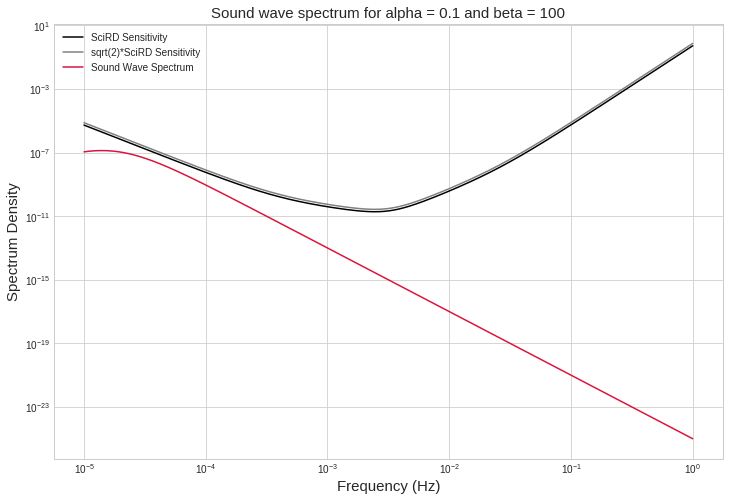

In [72]:
fig = plt.figure(figsize=[12,8])
ax = plt.axes()
#ax.axvline(df.Frequency[fid_start],0.,1.,color = 'black') # Uncomment to plot the range of the partial integration 
#ax.axvline(df.Frequency[fid_end],0.,1.,color = 'black')   # Uncomment to plot the range of the partial integration
ax.loglog()
ax.plot(df.Frequency, df.SciRD_Sensitivity, color = 'black', label = 'SciRD Sensitivity')
ax.plot(df.Frequency, df.Sqrt_Sensitivity, color = 'grey', label = 'sqrt(2)*SciRD Sensitivity')
ax.plot(df.Frequency, df.SwSpectrum, color = 'crimson', label = 'Sound Wave Spectrum')
ax.set_xlabel('Frequency (Hz)', fontsize = 15)
ax.set_ylabel('Spectrum Density', fontsize = 15)
ax.set_title('Sound wave spectrum for alpha = 0.1 and beta = 100', fontsize = 15)
ax.legend()
fig.savefig('SpectrumDensity80GevHigherRange.png', dpi = 500)

We now had to find the index for the starting and ending point of the integration of the SNR within the window :

In [20]:
#f_sw = Find_fsw(alpha, norm_beta)
#fid_start,fid_end =IntExtremes(f_sw,window)

Hence the SNR for the different sensitivities are given by :

In [73]:
# Uncomment the next line for an SNR within the Window
#SNR1, SNR2, SNR3 = SNR(fid_start,fid_end)
# Uncomment the next line for an SNR over all the frequency range 
SNR1, SNR2, SNR3 = SNR(0,len(df.Frequency) - 1)
print("The SNR with test values for a 3 year observation is :", SNR1)
print("The SNR with test values for a 3.75 year observation is :", SNR2)
print("The SNR with test values for a 4.5 year observation is :", SNR3)

The SNR with test values for a 3 year observation is : 23.6002038289802
The SNR with test values for a 3.75 year observation is : 26.385830022225274
The SNR with test values for a 4.5 year observation is : 28.904228603339643


We now have to show as the SNR behaves in function of the spanned variables, let's define some result matrix :

In [22]:
Z1 = np.zeros((100,100))
Z2 = np.zeros((100,100))
Z3 = np.zeros((100,100))

Let's also define the span of the two variables as :

In [23]:
log_span_alpha = np.linspace(-2,0,100)
span_alpha = 1*10**(log_span_alpha)
log_span_beta = np.linspace(0,4,100)
span_beta = 1.*10**(log_span_beta)
X, Y = np.meshgrid(span_alpha, span_beta)

We just have to run over the simulation over the values :

In [24]:
for i in range(100):
    if(i % 10 == 0):
        print('Percentage of completition : ',i,'%')
    for j in range(100):
        df['SwSpectrum'] = OmegaSW(df['Frequency'], X[j][i], Y[j][i])
        
        #Uncomment this section for an SNR analysis within the window
        
        #f_sw = Find_fsw(X[j][i], Y[j][i])
        #fid_start,fid_end =IntExtremes(f_sw,window)
        #Z1[j][i],Z2[j][i],Z3[j][i] = SNR(fid_start,fid_end)
        
        #Uncomment this section for an SNR analysis in the whole Frequency range
        
        Z1[j][i],Z2[j][i],Z3[j][i] = SNR(0, len(df.Frequency) - 1)

Percentage of completition :  0 %
Percentage of completition :  10 %
Percentage of completition :  20 %
Percentage of completition :  30 %
Percentage of completition :  40 %
Percentage of completition :  50 %
Percentage of completition :  60 %
Percentage of completition :  70 %
Percentage of completition :  80 %
Percentage of completition :  90 %


We just have to plot the results for the 3 different sensitivity curves :

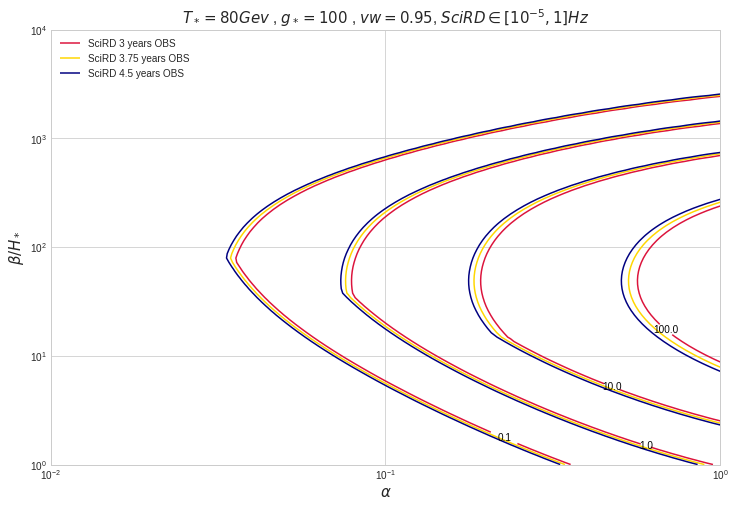

In [25]:
# Uncomment this block for a single plot of the 3 contour line

fig, ax = plt.subplots(figsize = [12,8])
c1 = ax.contour(X, Y, Z1, levels=[0.1, 1, 10, 100], colors = 'crimson');
c2 = ax.contour(X, Y, Z2, levels=[0.1, 1, 10, 100], colors = 'gold');
c3 = ax.contour(X, Y, Z3, levels=[0.1, 1, 10, 100], colors='navy');
ax.clabel(c1, inline=True, fmt = '%1.1f', fontsize=10, colors = 'black')
lines = [ c1.collections[0], c2.collections[0], c3.collections[0]]
labels = ['SciRD 3 years OBS','SciRD 3.75 years OBS','SciRD 4.5 years OBS']
ax.set_xlabel(r'$\alpha$', fontsize = 15)
ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)
ax.loglog()
ax.set_title('$T_* = 80 Gev$ , $g_* = 100$ , $vw = 0.95$, $SciRD \in [10^{-5},1] Hz$', fontsize = 15)
plt.legend(lines, labels, loc=2)
fig.savefig('FOM80GevCase3.png', dpi = 500)

In [26]:
# Uncomment the next 3 block for the single plots

#fig, ax = plt.subplots(figsize = [12,8])
#c1 = ax.contour(X, Y, Z1, levels=[1, 10,50,100], cmap = 'jet');
#ax.clabel(c1, inline=True, fmt = '%1.0f', fontsize=10, colors = 'black')
#lines = [ c1.collections[0]]
#labels = ['SciRD Sensitivity']
#ax.set_xlabel(r'$\alpha$', fontsize = 15)
#ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)

#ax.loglog()
#plt.legend(lines, labels)

In [27]:
#fig, ax = plt.subplots(figsize = [12,8])
#c2 = ax.contour(X, Y, Z2, levels=[1, 10,50,100], cmap = 'jet');
#ax.clabel(c2, inline=True, fmt = '%1.0f', fontsize=10, colors = 'black')
#lines = [c2.collections[0]]
#labels = ['1st Degradation']
#ax.set_xlabel(r'$\alpha$', fontsize = 15)
#ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)

#ax.loglog()
#plt.legend(lines, labels)

In [28]:
#fig, ax = plt.subplots(figsize = [12,8])
#c3 = ax.contour(X, Y, Z3, levels=[1, 10,50,100], cmap = 'jet');
#ax.clabel(c3, inline=True, fmt = '%1.0f', fontsize=10, colors = 'black')
#lines = [c3.collections[0]]
#labels = ['2nd Degradation']
#ax.set_xlabel(r'$\alpha$', fontsize = 15)
#ax.set_ylabel(r'$\beta / H_*$', fontsize = 15)

#ax.loglog()
#plt.legend(lines, labels)